<a href="https://colab.research.google.com/github/lakatosgabor/autoencoder_molding_energy_data/blob/main/molding_energy_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Új szakasz adatbetöltés

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
file_path = "/content/drive/MyDrive/PhD/Saját cikkek/Shelly/85_device1.csv"

In [3]:
df = pd.read_csv(file_path)
df.head()

,ID,DEVICE_ID,LOG_TIME,A_ACT_POWER,A_APRT_POWER,A_CURRENT,A_FREQ,A_PF,A_VOLTAGE,B_ACT_POWER,...,PRODUCTION_STATUS,DEVSTATUS_NAME,DEVSTATUS_ID,PRODNAME,MOLD_NAME,MOLD_SPEED,ACTUALSCRAP,ACTUALQUANTITY,QUANTITY,ERROR_REASON
0,1251855,shellypro3em-a0dd6c9f5048,2025-07-14 08:00:04.084,1148.5,1606.0,6.806,50.0,0.74,236.0,2166.8,...,2,Termel A,5,KTY0819,SZR1137,11.95,528.0,418864.0,286000,NaN
1,1251859,shellypro3em-a0dd6c9f5048,2025-07-14 08:00:09.427,2876.7,3009.3,12.814,49.9,0.84,235.6,2223.3,...,2,Termel A,5,KTY0819,SZR1137,11.95,528.0,418864.0,286000,NaN
2,1251864,shellypro3em-a0dd6c9f5048,2025-07-14 08:00:13.490,2016.5,2310.2,9.829,50.0,0.78,235.6,1252.3,...,2,Termel A,5,KTY0819,SZR1137,11.95,528.0,418880.0,286000,NaN
3,1251867,shellypro3em-a0dd6c9f5048,2025-07-14 08:00:17.459,1891.5,1937.7,8.272,50.0,0.77,235.8,1165.7,...,2,Termel A,5,KTY0819,SZR1137,11.95,528.0,418880.0,286000,NaN
4,1251869,shellypro3em-a0dd6c9f5048,2025-07-14 08:00:22.099,1638.3,2141.4,9.066,49.9,0.78,236.0,1028.9,...,2,Termel A,5,KTY0819,SZR1137,11.95,528.0,418880.0,286000,NaN


### Alap elemzés

In [4]:
# Dátum konvertálása
df["LOG_TIME"] = pd.to_datetime(df["LOG_TIME"])

# Teljesítmény oszlopok összege (három fázis alapján)
df["TOTAL_POWER"] = df["A_ACT_POWER"] + df["B_ACT_POWER"] + df["C_ACT_POWER"]

# Termelési állapot szerint szétválasztás
df_termel = df[df["PRODUCTION_STATUS"] == 2]
df_nem_termel = df[(df["PRODUCTION_STATUS"] != 2) & (df["TOTAL_POWER"] > 100)]

# Időkülönbség becsléséhez mintavételi időköz számítása
df_sorted = df.sort_values("LOG_TIME")
time_diffs = df_sorted["LOG_TIME"].diff().dropna()
avg_sample_rate_sec = time_diffs.dt.total_seconds().median()

# Teljes működési idő [óra] (minták száma * idő / 3600)
termel_idotartam_ora = len(df_termel) * avg_sample_rate_sec / 3600
nem_termel_idotartam_ora = len(df_nem_termel) * avg_sample_rate_sec / 3600

# Összes fogyasztás becslése [kWh]
termel_fogyasztas_kWh = df_termel["TOTAL_POWER"].sum() * avg_sample_rate_sec / 3600000
nem_termel_fogyasztas_kWh = df_nem_termel["TOTAL_POWER"].sum() * avg_sample_rate_sec / 3600000

{
    "mintavételi idő (s)": avg_sample_rate_sec,
    "termelési idő (óra)": termel_idotartam_ora,
    "nem termelési idő (óra, de van fogyasztás)": nem_termel_idotartam_ora,
    "termelés közbeni energiafogyasztás (kWh)": termel_fogyasztas_kWh,
    "nem termelés közbeni energiafogyasztás (kWh)": nem_termel_fogyasztas_kWh
}


{'mintavételi idő (s)': 5.266,
 'termelési idő (óra)': 2.928481111111111,
 'nem termelési idő (óra, de van fogyasztás)': 1.3150372222222222,
 'termelés közbeni energiafogyasztás (kWh)': np.float64(11.160222390333333),
 'nem termelés közbeni energiafogyasztás (kWh)': np.float64(0.6971882667777778)}

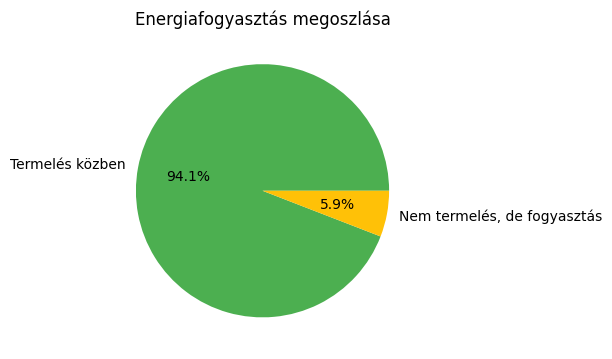

In [5]:
# 1. Energiafogyasztás megoszlása pie chart
labels = ['Termelés közben', 'Nem termelés, de fogyasztás']
values = [termel_fogyasztas_kWh, nem_termel_fogyasztas_kWh]

plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', colors=['#4CAF50', '#FFC107'])
plt.title('Energiafogyasztás megoszlása')
plt.tight_layout()
plt.show()

### Termelési adatok nélküli megjelenítés

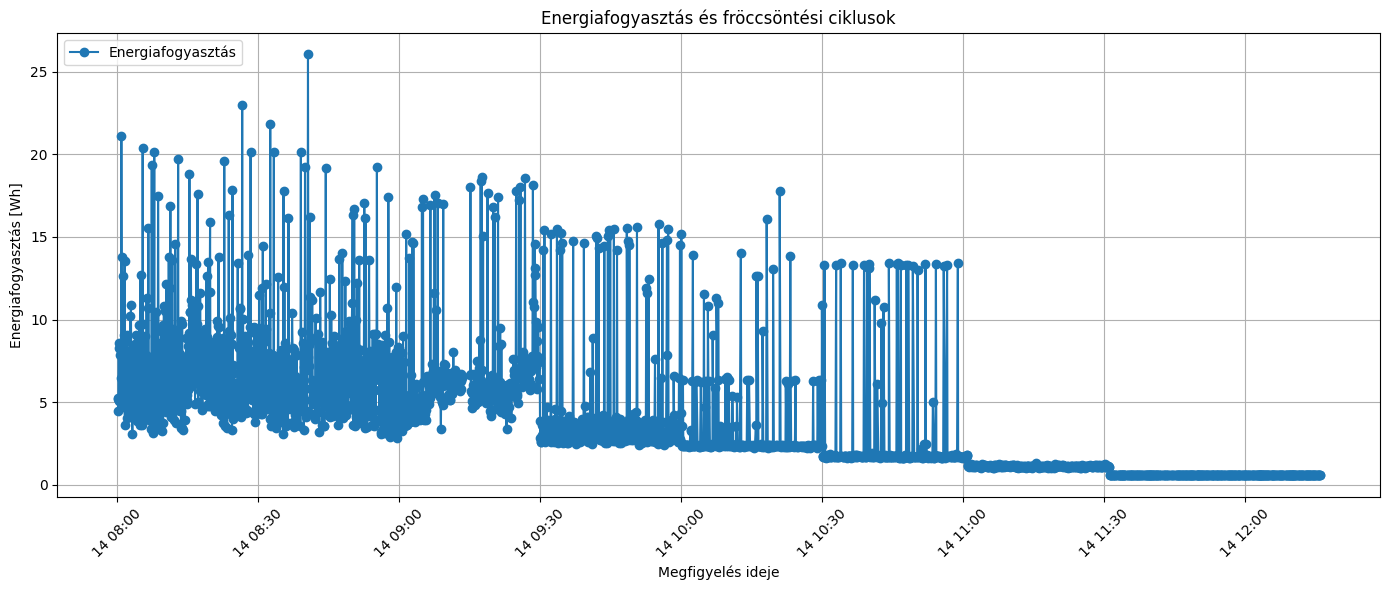

In [6]:
def calculate_energy_wh_kwh(active_power_watt, interval_seconds=5):
    """
    Kiszámítja az energiafogyasztást Wh mértékegységben.
    :param active_power_watt: Teljesítmény wattban (W)
    :param interval_seconds: A teljesítmény időintervalluma másodpercben (default: 5s)
    :return: Energiafogyasztás Wh-ban
    """
    energy_wh = active_power_watt * (interval_seconds / 3600)
    return energy_wh

def read_csv_and_plot_cycles(filepath, start_row=2, end_row=2600, interval_seconds=5):
    # Sorok beolvasása
    df = pd.read_csv(filepath, dtype=str, skiprows=lambda x: x != 0 and (x < start_row + 1 or x >= end_row + 1))


    # Szűrés
    df = df[df['PRODNAME'].isin(['KTY0819'])].copy()


    # Típuskonverziók
    df['TOTAL_ACT_POWER'] = df['TOTAL_ACT_POWER'].str.replace(',', '.', regex=False).astype(float)
    df['OBSERVATION_TIME'] = pd.to_datetime(df['OBSERVATION_TIME'], errors='coerce')
    df['ACTUALQUANTITY'] = pd.to_numeric(df['ACTUALQUANTITY'], errors='coerce').fillna(0)
    df['ACTUALSCRAP'] = pd.to_numeric(df['ACTUALSCRAP'], errors='coerce')

    # Energia számítás
    df['ENERGY_WH'] = df['TOTAL_ACT_POWER'].apply(lambda p: calculate_energy_wh_kwh(p, interval_seconds))

    # Grafikon rajzolása
    plt.figure(figsize=(14, 6))
    plt.plot(df['OBSERVATION_TIME'], df['ENERGY_WH'], marker='o', linestyle='-', label='Energiafogyasztás (Wh)')

    plt.title("Energiafogyasztás és fröccsöntési ciklusok")
    plt.xlabel("Megfigyelés ideje")
    plt.ylabel("Energiafogyasztás [Wh]")
    plt.legend(['Energiafogyasztás', 'Ciklus kezdete'], loc='upper left')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


read_csv_and_plot_cycles(file_path)

### Termelési adatok megjelenítése

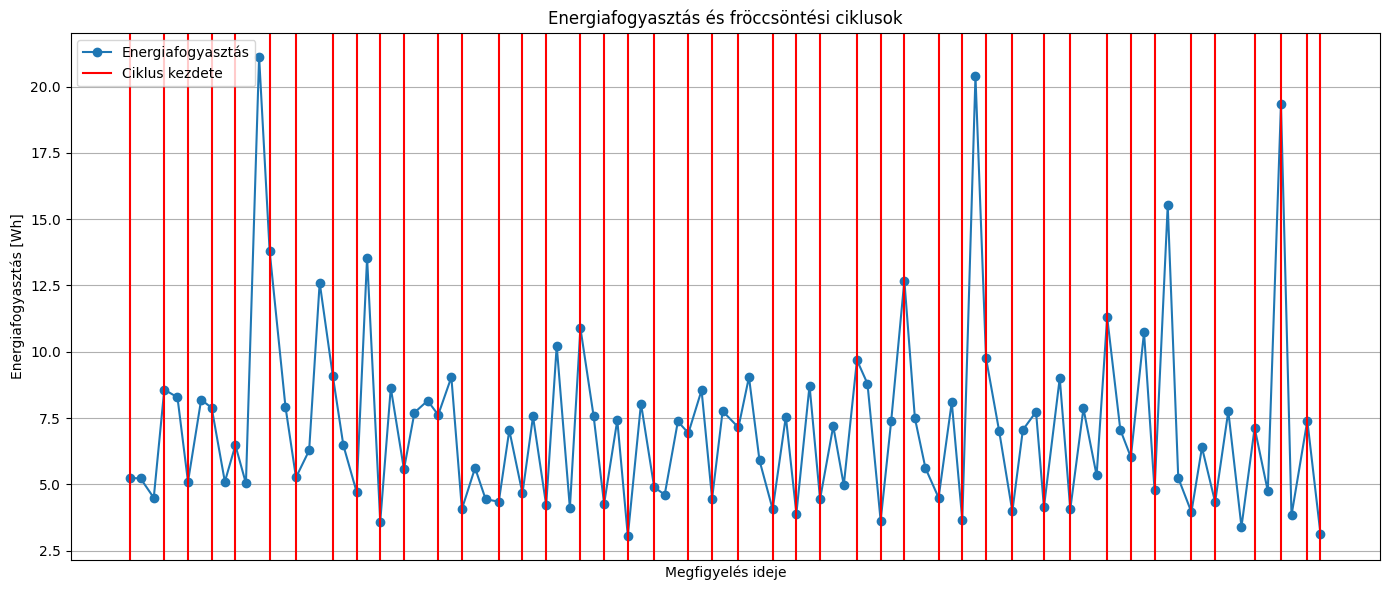

In [7]:
def calculate_energy_wh_kwh(active_power_watt, interval_seconds=5):
    """
    Kiszámítja az energiafogyasztást Wh mértékegységben.
    :param active_power_watt: Teljesítmény wattban (W)
    :param interval_seconds: A teljesítmény időintervalluma másodpercben (default: 5s)
    :return: Energiafogyasztás Wh-ban
    """
    energy_wh = active_power_watt * (interval_seconds / 3600)
    return energy_wh


def read_csv_and_plot_cycles(filepath, start_row=2, end_row=102, interval_seconds=5):
    # Sorok beolvasása
    df = pd.read_csv(filepath, dtype=str, skiprows=lambda x: x != 0 and (x < start_row + 1 or x >= end_row + 1))

    # Szűrés
    df = df[df['PRODNAME'].isin(['KTY0819'])].copy()

    # Típuskonverziók
    df['TOTAL_ACT_POWER'] = df['TOTAL_ACT_POWER'].str.replace(',', '.', regex=False).astype(float)
    df['OBSERVATION_TIME'] = pd.to_datetime(df['OBSERVATION_TIME'], errors='coerce')
    df['ACTUALQUANTITY'] = pd.to_numeric(df['ACTUALQUANTITY'], errors='coerce').fillna(0)
    df['ACTUALSCRAP'] = pd.to_numeric(df['ACTUALSCRAP'], errors='coerce')

    # Energia számítás
    df['ENERGY_WH'] = df['TOTAL_ACT_POWER'].apply(lambda p: calculate_energy_wh_kwh(p, interval_seconds))


    # Cikluskezdet: ha bármelyik érték változik (nem csak az egyik)
    quantity_changed = df['ACTUALQUANTITY'] != df['ACTUALQUANTITY'].shift(1)
    scrap_changed = df['ACTUALSCRAP'] != df['ACTUALSCRAP'].shift(1)
    df['IS_CYCLE_START'] = quantity_changed | scrap_changed

    # Grafikon rajzolása
    plt.figure(figsize=(14, 6))
    plt.plot(df['OBSERVATION_TIME'], df['ENERGY_WH'], marker='o', linestyle='-', label='Energiafogyasztás (Wh)')

    # Cikluskezdetek megjelölése
    for time in df[df['IS_CYCLE_START']]['OBSERVATION_TIME']:
        if pd.notna(time):
            plt.axvline(x=time, color='red', linestyle='-', alpha=1)

    plt.title("Energiafogyasztás és fröccsöntési ciklusok")
    plt.xlabel("Megfigyelés ideje")
    plt.ylabel("Energiafogyasztás [Wh]")
    plt.legend(['Energiafogyasztás', 'Ciklus kezdete'], loc='upper left')
    plt.grid(True)
    plt.xticks([])
    plt.tight_layout()
    plt.show()


read_csv_and_plot_cycles(file_path)


### Autoencoder

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.9760
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6825
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5448
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4118
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2672
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1299
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0505
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0252
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0205
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0199
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0184
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0151
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0149
Epoch 15/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133
Epo

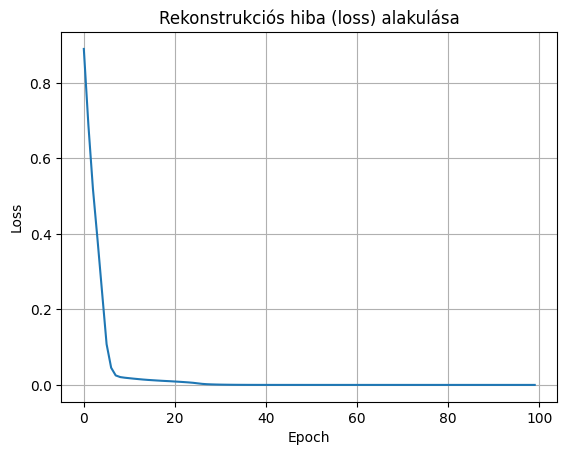

In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

# CSV beolvasása
df = pd.read_csv(file_path)  # ha más néven töltötted fel, írd át

# Teljesítmény (összes fázis) kiszámítása
df['TOTAL_POWER_W'] = df['A_ACT_POWER'] + df['B_ACT_POWER'] + df['C_ACT_POWER']

# Fogyasztás Wh-ban 5 másodperces mintavételezés alapján
df['ENERGY_Wh'] = (df['TOTAL_POWER_W'] * 5) / 3600

# Csak azok a sorok, amikor a gép termel (PRODUCTION_STATUS == 2)
df_prod = df[df['PRODUCTION_STATUS'] == 2].copy()

# Normál működés: az első 600 termelési sor
df_normal = df_prod[['ENERGY_Wh']].iloc[:600].copy()

# Skálázás
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df_normal)

# Autoencoder hálózat
input_dim = X_train_scaled.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(4, activation='relu')(input_layer)
encoded = Dense(2, activation='relu')(encoded)
decoded = Dense(4, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(0.001), loss='mse')

# Tanítás
history = autoencoder.fit(X_train_scaled, X_train_scaled,
                          epochs=100,
                          batch_size=16,
                          shuffle=True,
                          verbose=1)

# Loss kirajzolása
plt.plot(history.history['loss'])
plt.title('Rekonstrukciós hiba (loss) alakulása')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [10]:
# Tesztadatok a 600. sortól kezdődően (csak termelés közbeni sorok)
df_test = df_prod.iloc[2:2902].copy()
X_test_scaled = scaler.transform(df_test[['ENERGY_Wh']])

# Predikció és rekonstrukciós hiba kiszámítása
X_test_pred = autoencoder.predict(X_test_scaled)
reconstruction_errors = np.mean(np.square(X_test_scaled - X_test_pred), axis=1)

# Threshold meghatározása az oktatási adatok alapján (95. percentilis)
train_errors = np.mean(np.square(X_train_scaled - autoencoder.predict(X_train_scaled)), axis=1)
threshold = np.percentile(train_errors, 95)

# Anomália címke hozzáadása
df_test['reconstruction_error'] = reconstruction_errors
df_test['anomaly'] = df_test['reconstruction_error'] > threshold


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


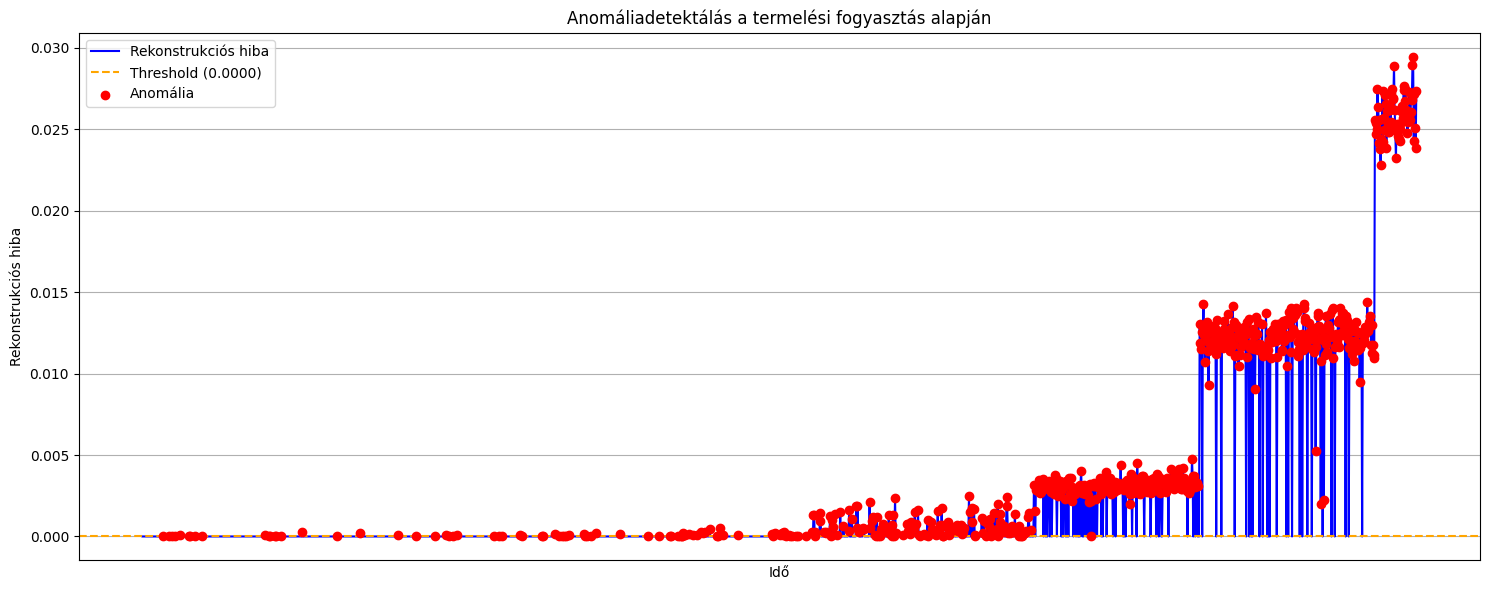

,MACHINENAME,TOTAL_ACT_POWER,OBSERVATION_TIME,PRODUCTIONSTATUS_NAME,DEVSTATUS_NAME,anomaly
34,FGP085,5069.642,2025-07-14 08:02:32.000,14_Termelés,Termel A,True
44,FGP085,2199.235,2025-07-14 08:03:17.000,14_Termelés,Termel A,True
49,FGP085,4992.443,2025-07-14 08:03:40.000,14_Termelés,Termel A,True
53,FGP085,5145.646,2025-07-14 08:03:59.000,14_Termelés,Termel A,True
61,FGP085,5182.773,2025-07-14 08:04:35.000,14_Termelés,Termel A,True
...,...,...,...,...,...,...
1997,FGP085,861.620,2025-07-14 11:06:42.000,14_Termelés,Kézi üzemmód,True
1998,FGP085,785.986,2025-07-14 11:06:46.000,14_Termelés,Kézi üzemmód,True
1999,FGP085,840.659,2025-07-14 11:06:48.000,14_Termelés,Kézi üzemmód,True
2000,FGP085,873.497,2025-07-14 11:06:57.000,14_Termelés,Kézi üzemmód,True


In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

# Rekonstrukciós hiba ábrázolása
plt.plot(df_test['LOG_TIME'], df_test['reconstruction_error'], label='Rekonstrukciós hiba', color='blue')

# Threshold vonal
plt.axhline(threshold, color='orange', linestyle='--', label=f'Threshold ({threshold:.4f})')

# Anomáliák piros pontokkal
anomalies = df_test[df_test['anomaly']]
plt.scatter(anomalies['LOG_TIME'], anomalies['reconstruction_error'], color='red', label='Anomália', zorder=5)

plt.title('Anomáliadetektálás a termelési fogyasztás alapján')
plt.xlabel('Idő')
plt.ylabel('Rekonstrukciós hiba')
plt.xticks([])
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

anomalies[['MACHINENAME', 'TOTAL_ACT_POWER', 'OBSERVATION_TIME', 'PRODUCTIONSTATUS_NAME', 'DEVSTATUS_NAME', 'anomaly']]

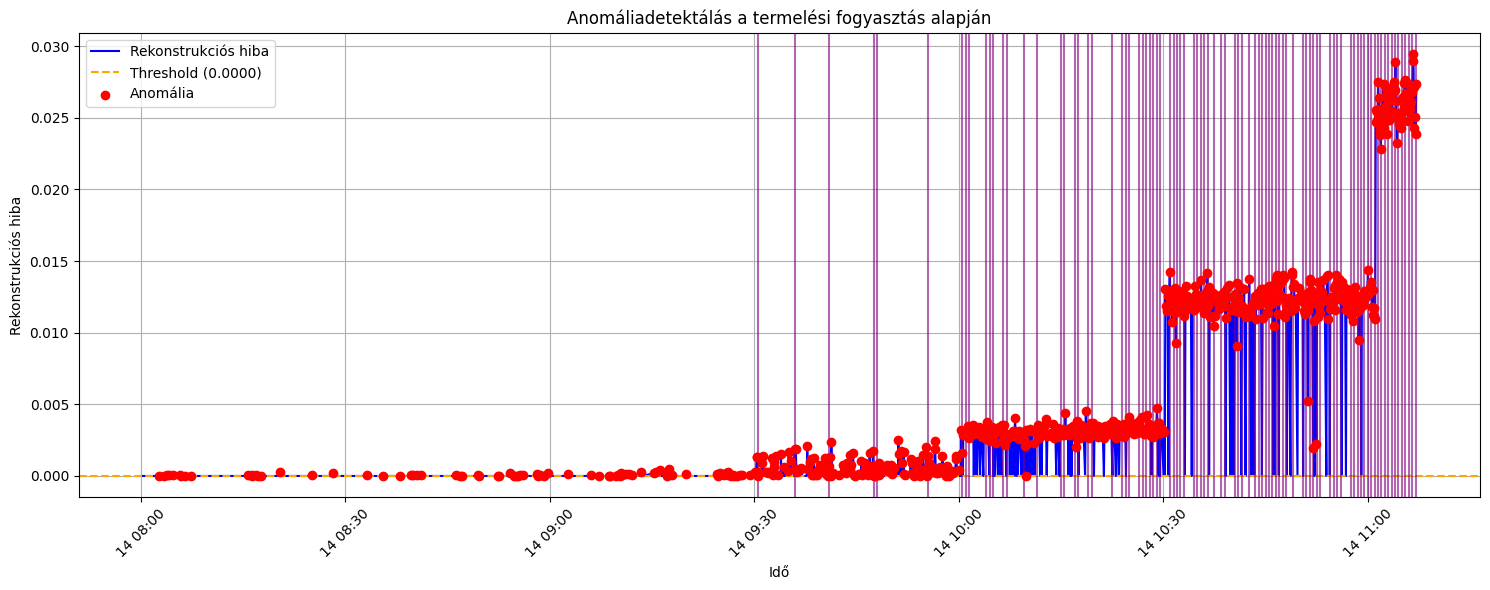

In [27]:
import matplotlib.pyplot as plt

df_test['LOG_TIME'] = pd.to_datetime(df_test['LOG_TIME'])

anomalies = df_test[df_test['anomaly']].copy()
anomalies_sorted = anomalies.sort_values('LOG_TIME').set_index('LOG_TIME')

# 30 másodperces gördülő ablakban számolja az anomáliák számát
anomalies_sorted['anom_count_30sec'] = anomalies_sorted['anomaly'].rolling('30s').count()

# 5 vagy több anomália 30 másodpercen belül
frequent_anomalies = anomalies_sorted[anomalies_sorted['anom_count_30sec'] >= 5].copy()

unique_times = []
if not frequent_anomalies.empty:
    # Lekerekítés 30 mp-es ablakokhoz (lehet '30s' vagy '15s' a pontos igény szerint)
    frequent_anomalies['alert_time'] = frequent_anomalies.index.floor('30s')
    unique_times = frequent_anomalies['alert_time'].drop_duplicates()

# --- ÁBRA ---
plt.figure(figsize=(15, 6))

# Rekonstrukciós hiba vonal
plt.plot(df_test['LOG_TIME'], df_test['reconstruction_error'], label='Rekonstrukciós hiba', color='blue')

# Threshold vonal
plt.axhline(threshold, color='orange', linestyle='--', label=f'Threshold ({threshold:.4f})')

# Anomáliák piros pontokkal
plt.scatter(anomalies['LOG_TIME'], anomalies['reconstruction_error'], color='red', label='Anomália', zorder=5)

# Riasztási pontok függőleges vonallal
for riasztas_idopont in unique_times:
    plt.axvline(x=riasztas_idopont, color='purple', linestyle='-', linewidth=1.5, alpha=0.6)

# A legenda ne ismétlődjön minden vonalhoz
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title('Anomáliadetektálás a termelési fogyasztás alapján')
plt.xlabel('Idő')
plt.ylabel('Rekonstrukciós hiba')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
